# NeuroMANCER parameter estimation of an ODE system

In this example we are concerned with a parameter estimation of white-box [ordinary differential equation](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).


## System Identification Problem Setup

<img src="../figs/ODE.PNG" width="400">  

 Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ into the ODE model $N$, producing a derivative that is
integrated using an integration scheme $\int$. In system identification, the loss $L$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### References

[1] Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages. https://doi.org/10.1145/3567591


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import argparse
from torch.utils.data import DataLoader
import os

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dynamics.ode import ODESystem
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.psl import plot
from neuromancer import psl

torch.manual_seed(0)

## Generate trajectories from ODE system to model

Consider the [Brusselator system](https://en.wikipedia.org/wiki/Brusselator) defined by the following ODE: 

$$
 \frac{dx_1}{dt} = \alpha + x_2 x_1^2 -\beta x_1 -x_1  \\  
 \frac{dx_2}{dt} = \beta x_1 - x_2 x_1^2
$$  

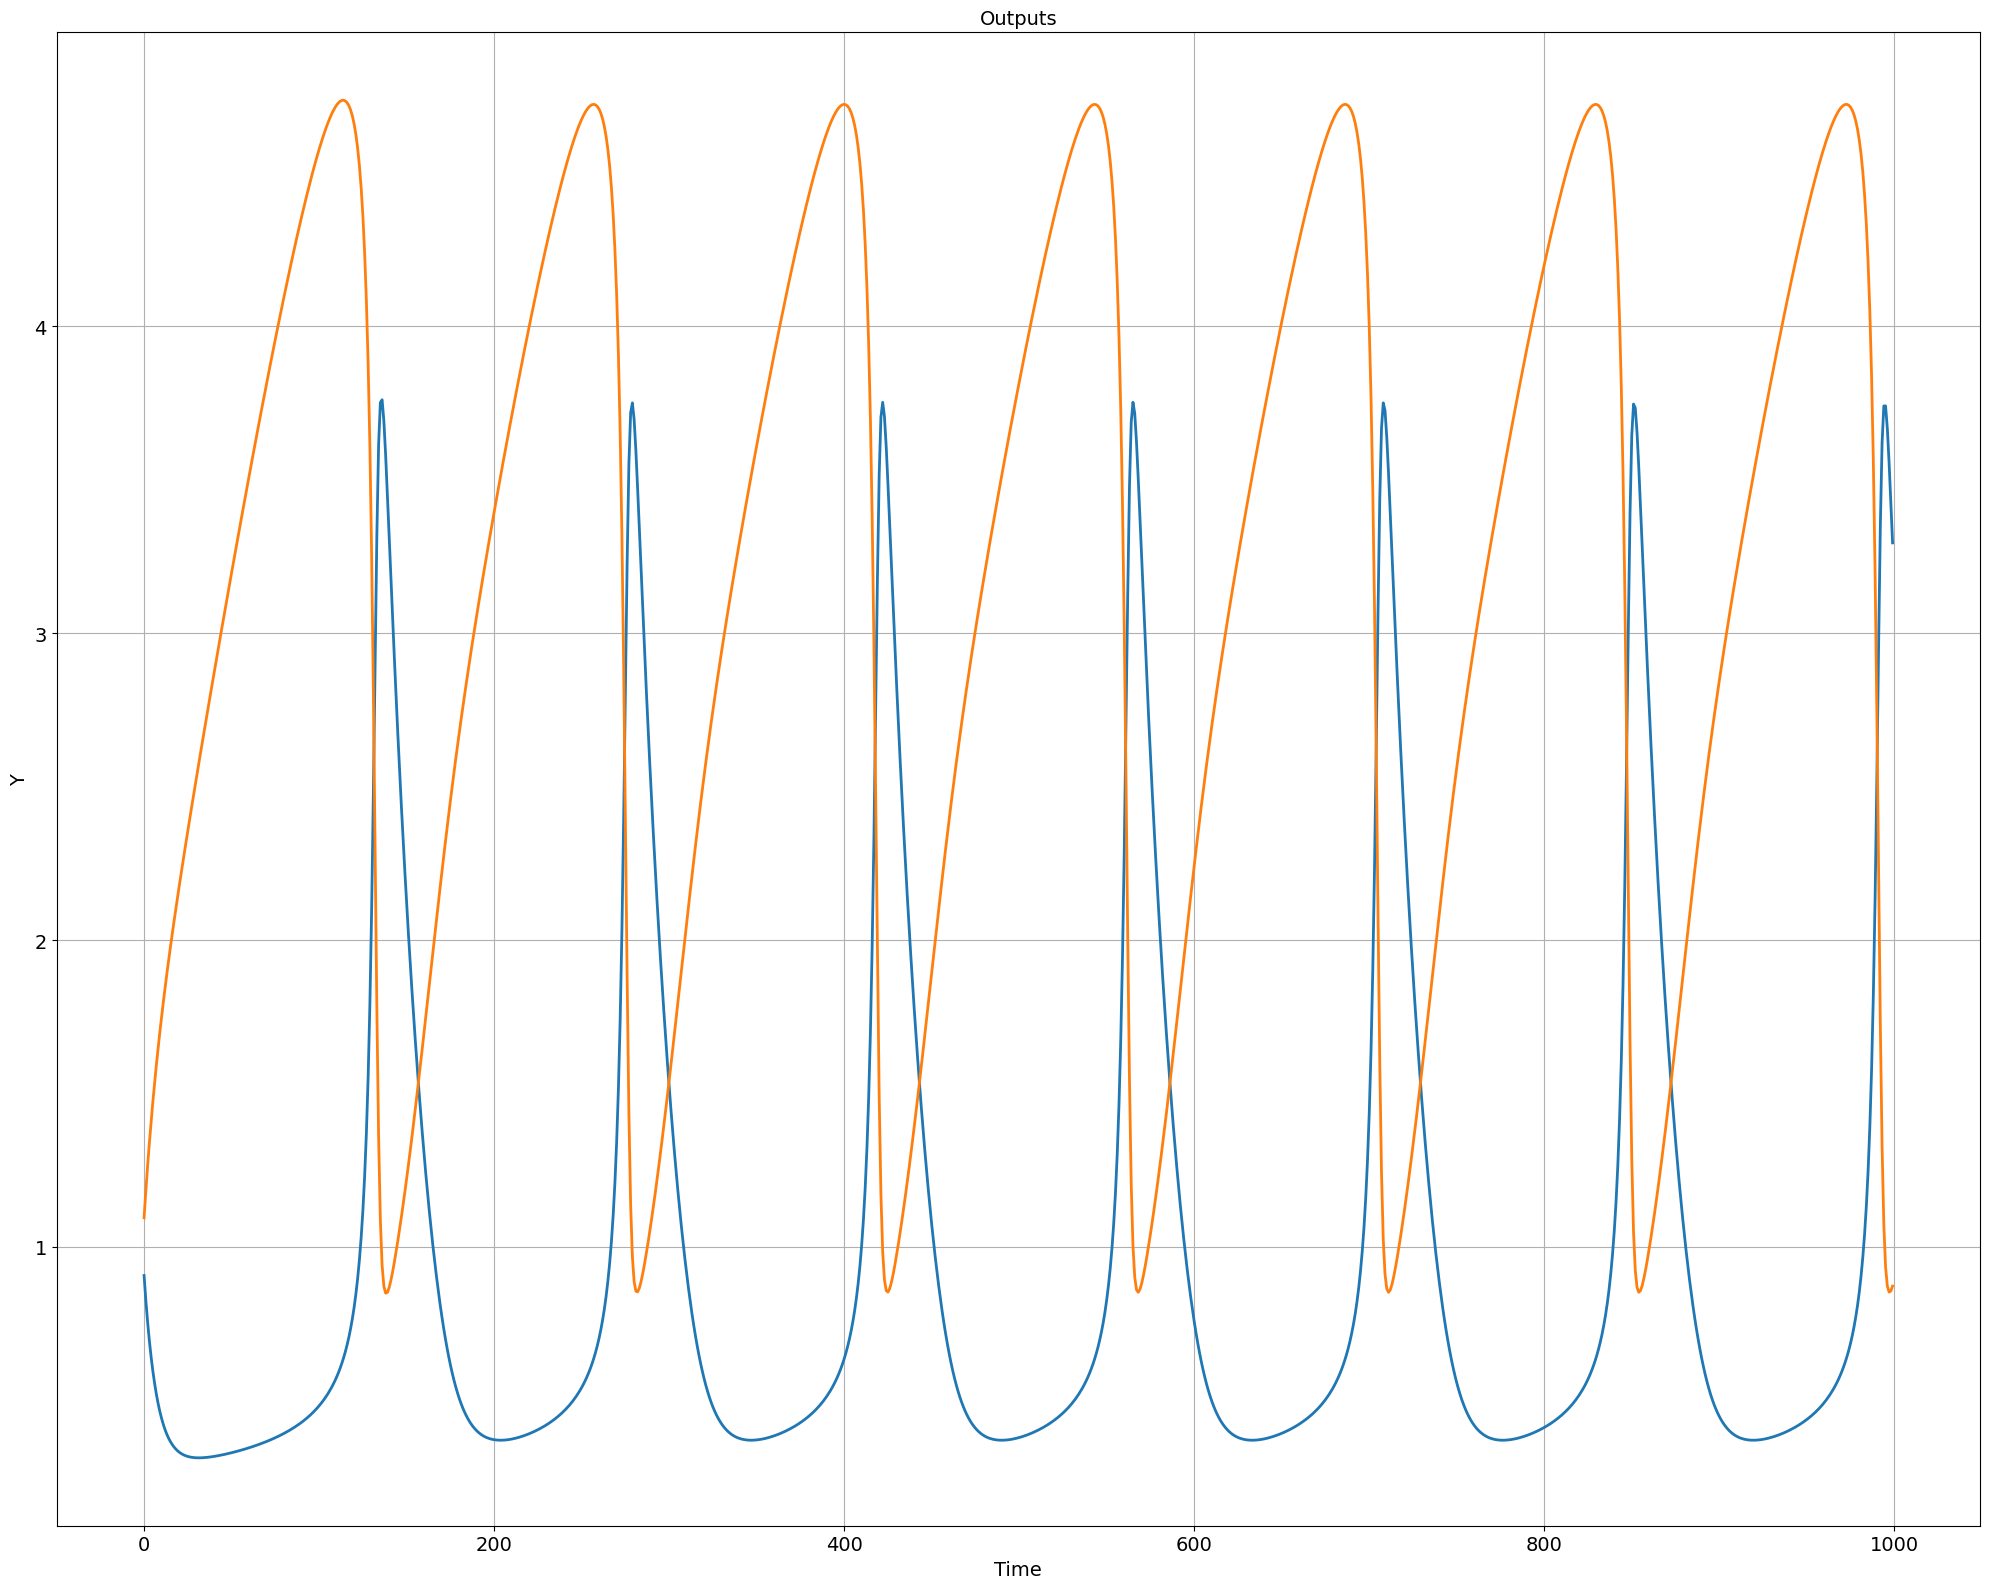

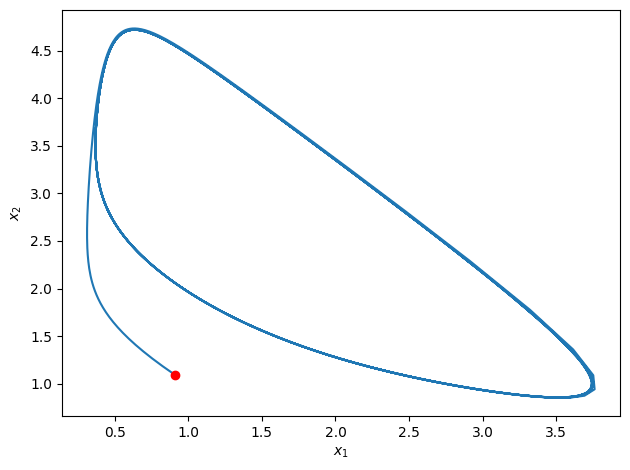

In [3]:
# %%  ground truth system
system = psl.systems['Brusselator1D']
ts = 0.05
modelSystem = system()
nx = modelSystem.nx
# simualte ground truth system
raw = modelSystem.simulate(nsim=1000, ts=ts)
# plot trajectories
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [4]:
def get_data(sys, nsim, nsteps, bs):
    """
    :param sys: (psl system)
    :param nsim: (int) Number of simulation steps of the true ODE model
    :param nsteps: (int) Number of prediction horizon timesteps 
    :param bs: (int) batch size for minibatching

    """
    # simulate trajectories of a real system to generate the datasets    
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=0.05) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    # training dataset
    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    # development dataset
    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)
    # test dataset
    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [5]:
nsim = 500   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 32     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, bs)

## ODE system model in Neuromancer

Here we construct a continuous-time ODE model  $\dot{x} = f_{\theta}(x)$ with trainable parameters $\theta$.

In [6]:
# define ODE system in Neuromancer
class BrusselatorParam(ODESystem):
    def __init__(self, insize=2, outsize=2):
        super().__init__(insize=insize, outsize=outsize)
        self.alpha = nn.Parameter(torch.tensor([5.0]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([5.0]), requires_grad=True)
    
    def ode_equations(self, x):
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha + x2*x1**2 - self.beta*x1 - x1
        dx2 = self.beta*x1 - x2*x1**2
        return torch.cat([dx1, dx2], dim=-1)

Here we construct an open-loop system composed of the ODE models solved with ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods):  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated ODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).

Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class. In this example we will use BPTT algorithm through unrolled RK4 solver.

In [7]:
# instantiate ODE system
brussels = BrusselatorParam()
# use ODE solver to discretize the ODE with a given timestep h
fxRK4 = integrators.RK4(brussels, h=ts)
# create symbolic system model in Neuromancer
dynamics_model = System([Node(fxRK4, ['xn'], ['xn'])], nsteps=nsteps)

In [8]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_x||x^i_k - \hat{x}^i_k||_2^2$$ 
**Finite difference loss:**  
$$\ell_{dx} =  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2$$
where $\Delta x^i_k = x^i_{k+1} - x^i_k$

In [9]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# define finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# finite difference loss - i.e., fitting first derivatives
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(\sum_{k=1}^{N}  Q_x||x^i_k - \hat{x}^i_k||_2^2  +  \sum_{k=1}^{N-1}  Q_{dx}||\Delta x^i_k - \Delta \hat{x}^i_k||_2^2  \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k)) \\
\end{align}
$$  

In [10]:
# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [11]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown ODE parameters $\theta$ using stochastic gradient descent.

In [12]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.1)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=10,
    warmup=10,
    epochs=100,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss")

In [13]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 0.0288230013102293
epoch: 1  train_loss: 0.017091521993279457
epoch: 2  train_loss: 0.009261596947908401
epoch: 3  train_loss: 0.004228680860251188
epoch: 4  train_loss: 0.0015729435253888369
epoch: 5  train_loss: 0.0003902610915247351
epoch: 6  train_loss: 5.262921695248224e-05
epoch: 7  train_loss: 5.848890396009665e-06
epoch: 8  train_loss: 2.2836271455162205e-05
epoch: 9  train_loss: 2.3258144210558385e-05
epoch: 10  train_loss: 1.2638778571272269e-05
epoch: 11  train_loss: 4.155470378464088e-06
epoch: 12  train_loss: 5.376450644689612e-07
epoch: 13  train_loss: 7.427908599311195e-08
epoch: 14  train_loss: 2.137195451723528e-07
epoch: 15  train_loss: 1.8988642125350452e-07
epoch: 16  train_loss: 7.968330351104669e-08
epoch: 17  train_loss: 1.4315766350136983e-08
epoch: 18  train_loss: 2.349537897572418e-09
epoch: 19  train_loss: 4.272514786407555e-09
epoch: 20  train_loss: 4.045462187463045e-09
epoch: 21  train_loss: 2.3972033247332547e-09
epoch: 22  train_los

<All keys matched successfully>

## Parameter estimation results

In [14]:
# trained parameters
print('alpha = '+str(brussels.alpha.item()))
print('beta = '+str(brussels.beta.item()))

alpha = 1.0000513792037964
beta = 2.999898672103882


In [15]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [16]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

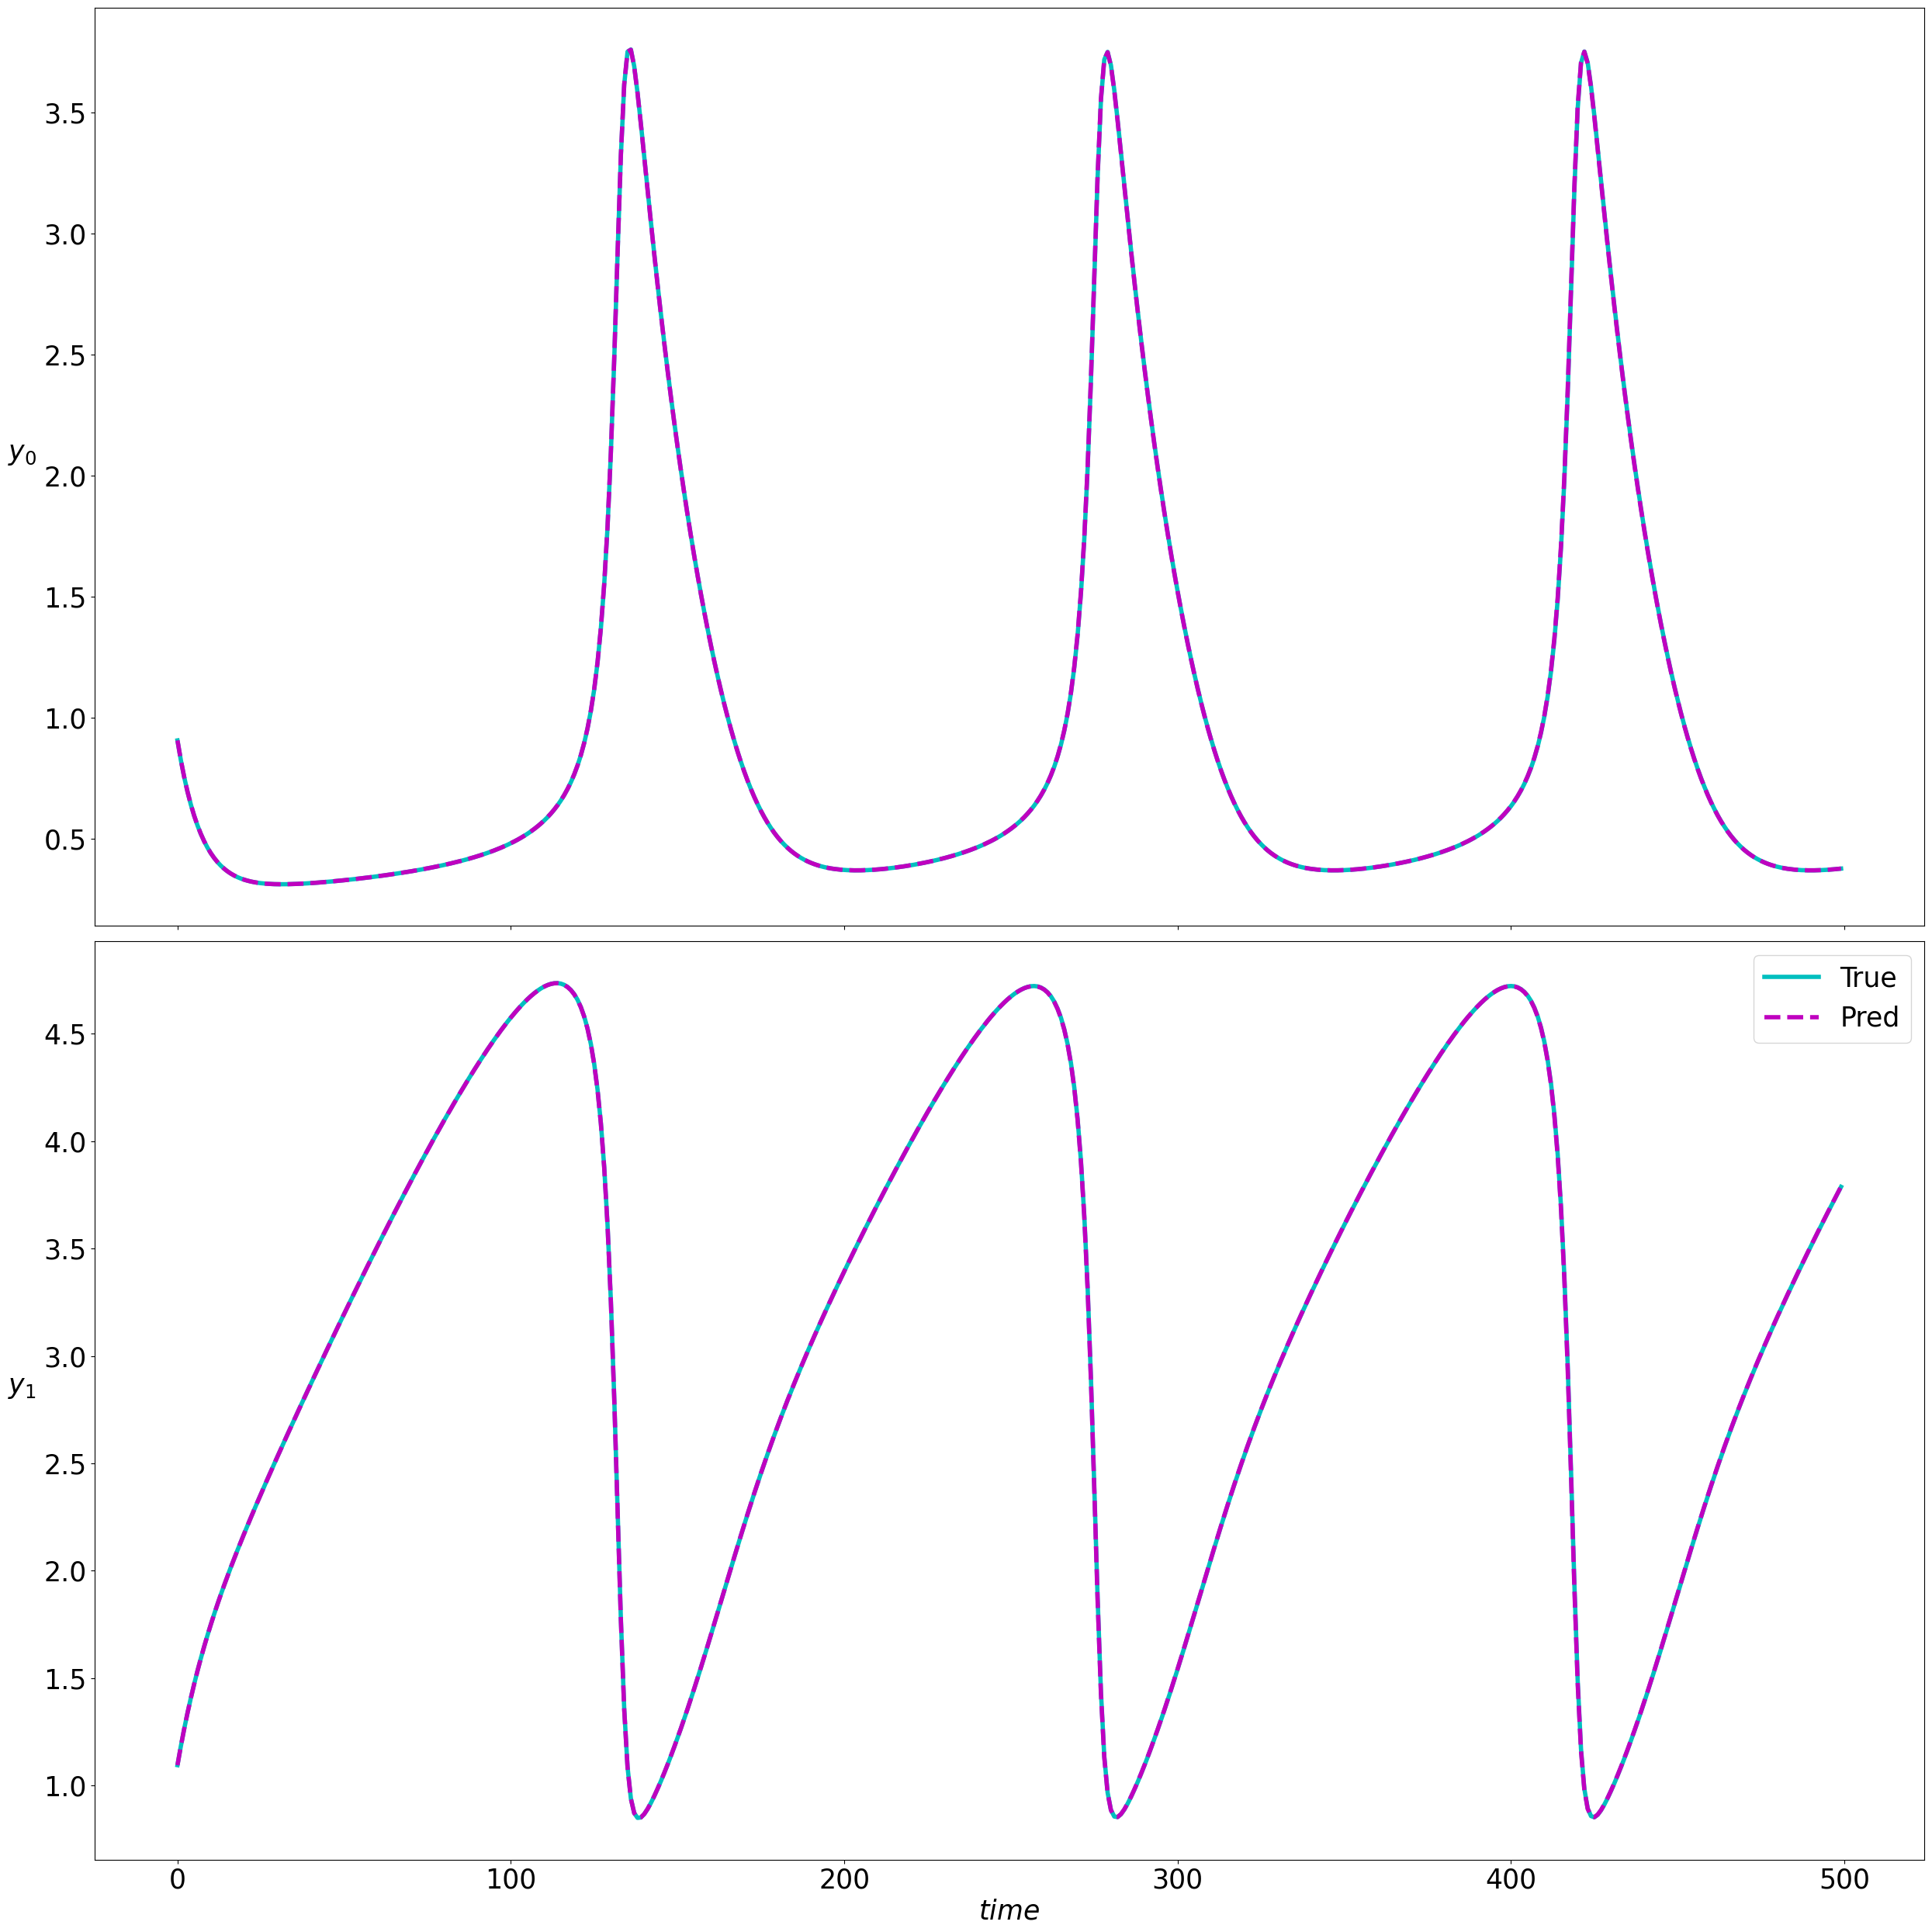

In [17]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()
# plt.savefig('open_loop.png')
